In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import seaborn as sns
import mapclassify as mc
import matplotlib.pyplot as plt


In [2]:
dataset = pd.read_pickle('../../geodata/results/02_spatial_lagged_master.pkl')
# dataset = pd.read_pickle('../../../geodata/results/02_spatial_lagged_master.pkl')

In [3]:
gdf_hexbn = gpd.read_file('../../geodata/ch_spatialbins/hexbin_viewdata.gpkg').dropna()


In [4]:
import mapclassify as mc
n = 30
max_slope = dataset['nabr_med_slope'].max()
max_count = dataset['nabr_count'].max()
bin_slope = mc.NaturalBreaks(gdf_hexbn.query('slope_median < @max_slope').slope_median.dropna(), k = n).bins.round().astype('int')
bin_count = mc.Quantiles(gdf_hexbn.query('count < @max_count')['count'].dropna(), k = n).bins.round().astype('int')


c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 30 classes. Setting k to 28.
  warnings.warn(


In [5]:
dataset['slope_bin'] = pd.cut(dataset['nabr_med_slope'], bins=bin_slope)
dataset['bdensity_bin'] = pd.cut(dataset['nabr_count'], bins=bin_count)

r_bldg = dataset['bdensity_bin'].cat.categories.right.map(int).astype(str)
r_slope = dataset['slope_bin'].cat.categories.right.map(int).astype(str)+u'\N{DEGREE SIGN}'

dataset['slope_bin'] = dataset['slope_bin'].cat.rename_categories(dict(zip(dataset['slope_bin'].cat.categories,r_slope)))
dataset['bdensity_bin'] = dataset['bdensity_bin'].cat.rename_categories(dict(zip(dataset['bdensity_bin'].cat.categories,r_bldg)))

In [74]:
def plot_heat(x, cmap, title, ax , alpha, cbar = True):
    sns.heatmap(x, ax=ax,cmap = cmap, square = True, linewidths=0, alpha = alpha, cbar = cbar, cbar_kws={'label': 'VC Skew','shrink': 0.5, 'orientation': 'vertical'})
    # ax.set_title('Average Net-Income')
    # ax.set_yticklabels(r_bldg,  rotation = 0)
    # ax.set_xticklabels(r_slope+u'\N{DEGREE SIGN}', rotation = 0)
    ax.set_axisbelow(True)
    # ax.xaxis.grid(color='gray', linestyle='dashed')
    # ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_title(title, ha = 'left', x= 0)
    ax.set_xlabel('Terrain Slope')
    ax.set_ylabel('Building Density')
    

In [42]:
dataset = dataset.assign(pred = dataset['XGB'].round(0))

In [44]:
sns.set_theme()
# sns.set_style('white')
sns.set_context("paper", font_scale = 1)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rcParams['svg.fonttype'] = 'none'

TypeError: 'Axes' object is not subscriptable

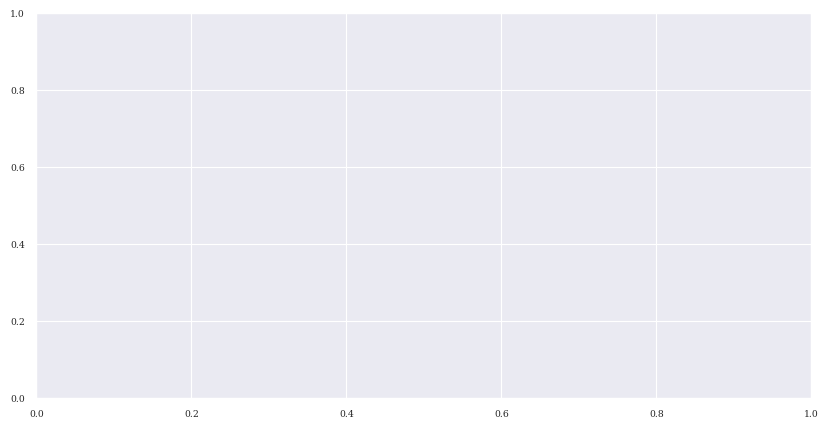

In [141]:
fig, (axes) = plt.subplots(1,1, figsize = (10,5), sharex=True, sharey=True)

Xcount = dataset.groupby(['slope_bin','bdensity_bin'])['nabr_avg_pred'].count().unstack()
X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['nabr_avg_pred'].skew().unstack()

thr = 1000

plot_heat(X_vc[Xcount <= thr].T,'Greys', '', axes[0], .25, False)
plot_heat(X_vc[Xcount > thr].T,'magma', '', axes[0], 1, True)

plt.tight_layout()

Text(0.5, 0.98, 'Urban and Natural Form')

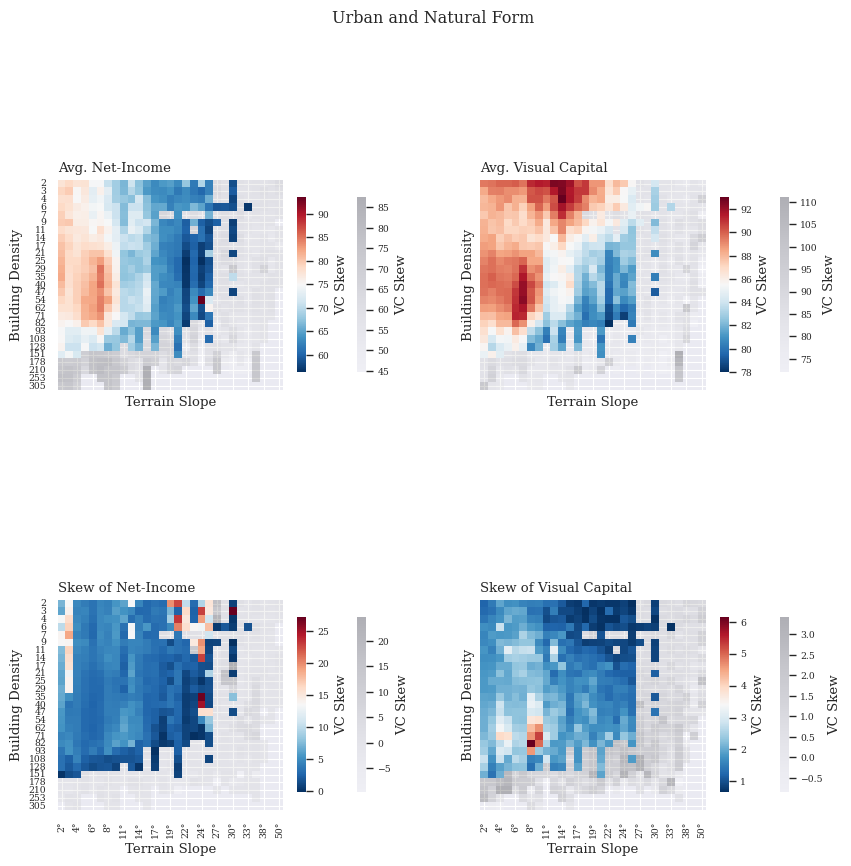

In [143]:
fig, (axes) = plt.subplots(2,2, figsize = (10,10), sharex=True, sharey=True)

Xcount = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].count().unstack()
X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].mean().unstack()
X_income = dataset.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].mean().unstack()

thr = 1000

plot_heat(X_income[Xcount <= thr].T, 'Greys', '', axes[0,0], .25)
plot_heat(X_income[Xcount > thr].T,'RdBu_r', 'Avg. Net-Income', axes[0,0], 1)

plot_heat(X_vc[Xcount <= thr].T,'Greys', '', axes[0,1], .25)
plot_heat(X_vc[Xcount > thr].T,'RdBu_r', 'Avg. Visual Capital', axes[0,1], 1)

X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].skew().unstack()
X_income = dataset.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].skew().unstack()

plot_heat(X_income[Xcount <= thr].T, 'Greys', '', axes[1,0], .25)
plot_heat(X_income[Xcount > thr].T,'RdBu_r', 'Skew of Net-Income', axes[1,0], 1)

plot_heat(X_vc[Xcount <= thr].T,'Greys', '', axes[1,1], .25)
plot_heat(X_vc[Xcount > thr].T,'RdBu_r', 'Skew of Visual Capital', axes[1,1], 1)

plt.suptitle('Urban and Natural Form')
# plt.tight_layout()

# plt.savefig('../../vc_plots/income_vc_across_urban_nat_form.svg')

In [ ]:
X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].mean().unstack()
sns.heatmap(x, ax=ax,cmap = cmap, square = True, linewidths=0, alpha = alpha, cbar = False)

In [2]:
gdf_hexbin = pd.read_pickle('../../../geodata/results/04_vm_hexbin.pkl')
gdf_commune = pd.read_pickle('../../../geodata/results/04_vm_commune.pkl')

In [24]:
def binfeat(x, n):
    bin_me = mc.NaturalBreaks(x.dropna(), k = n).bins.round().astype('int')
    return pd.cut(x, bins = bin_me, include_lowest = True)

gdf_hexbin['slope_bin'] = binfeat(gdf_hexbin.slope_median, 25)
gdf_hexbin['bdensity_bin'] = binfeat(gdf_hexbin['count'], 25)
gdf_hexbin['avg_bin'] = binfeat(gdf_hexbin.avg, 10)

r_bldg = gdf_hexbin['bdensity_bin'].cat.categories.right.map(int).astype(str)
r_slope = gdf_hexbin['slope_bin'].cat.categories.right.map(int).astype(str)

In [33]:
def binfeat(x, n):
    bin_me = mc.Quantiles(x.dropna(), k = n).bins
    return pd.cut(x, bins = bin_me)

gdf_hexbin['slope_bin'] = binfeat(gdf_hexbin.slope_mean, 25)
gdf_hexbin['bdensity_bin'] = binfeat(gdf_hexbin['count'], 25)
gdf_hexbin['avg_bin'] = binfeat(gdf_hexbin.avg, 10)

<Axes: xlabel='bdensity_bin', ylabel='slope_bin'>

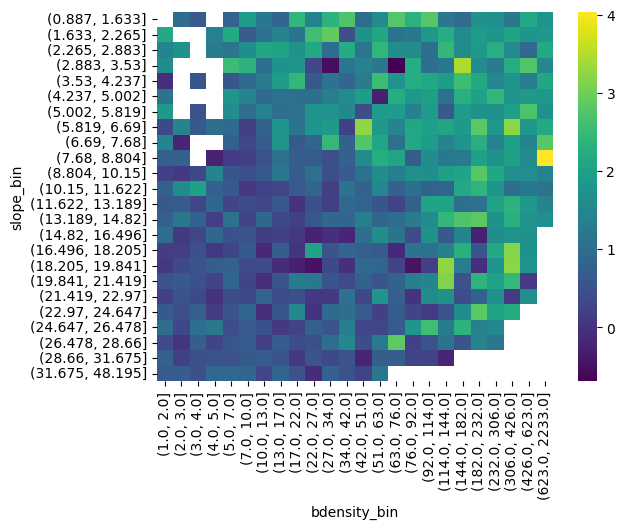

In [42]:
Xcount = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['avg'].count().unstack()
X = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['avg'].skew().unstack()

X = X[Xcount > 10]

sns.heatmap(X, cmap = 'viridis')

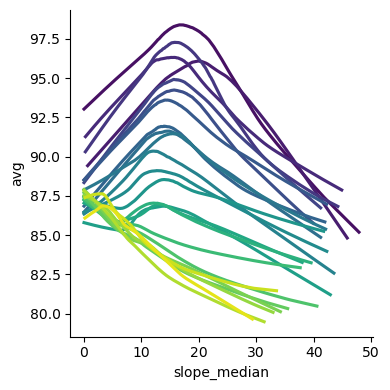

In [38]:
sns.lmplot(data = gdf_hexbin.dropna(), 
            x = 'slope_median', y = 'avg', hue ='bdensity_bin' , 
            scatter = False, lowess = True, palette = 'viridis', ci = .95, height = 4, legend = False)


Text(1044.6767676767674, 0.5, 'Building Density')

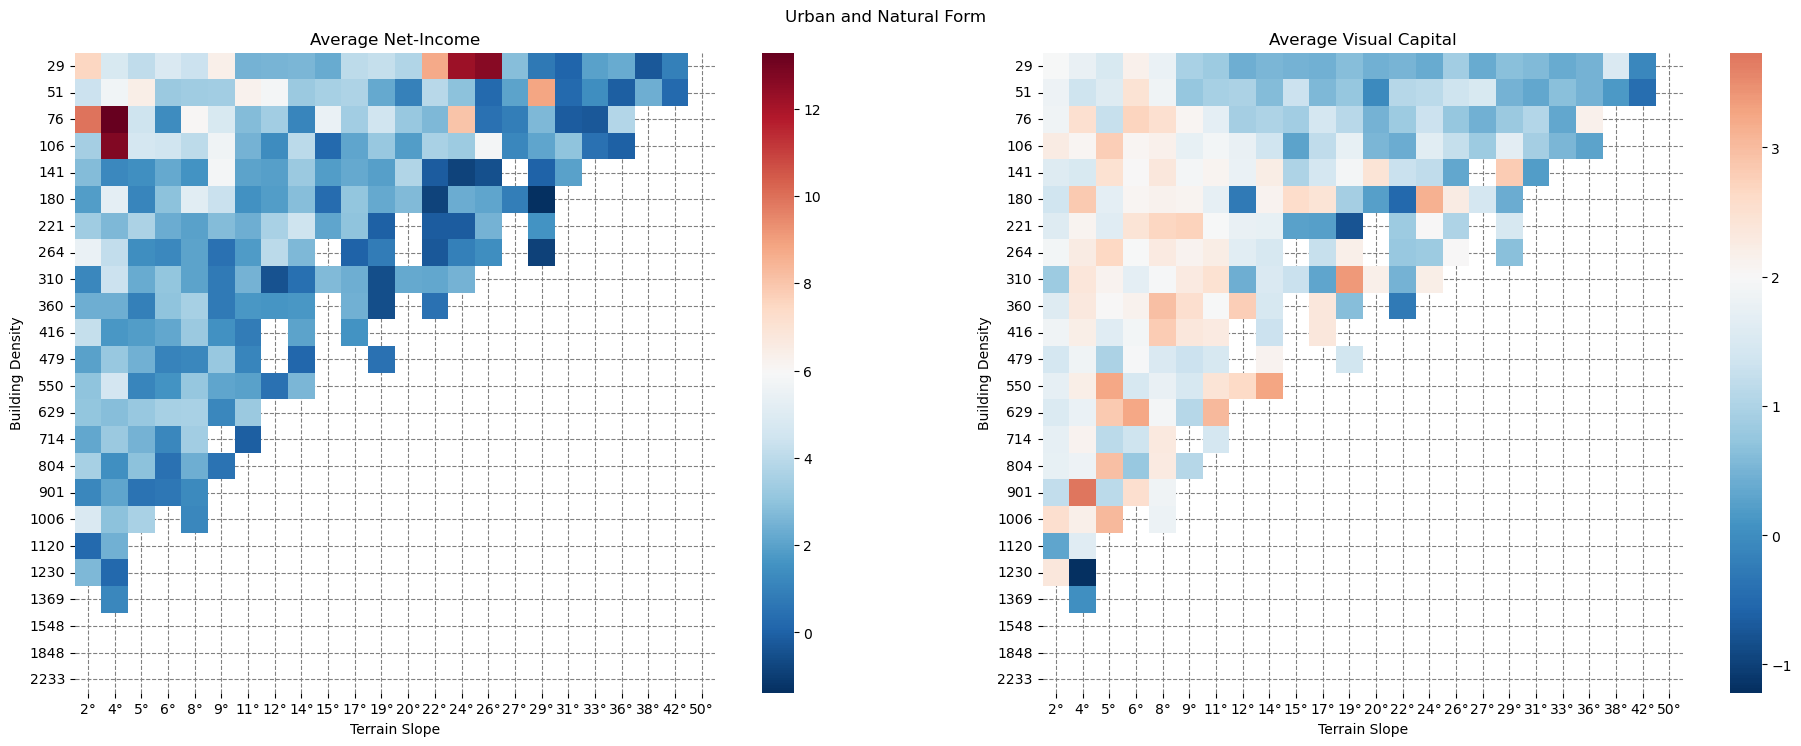

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7.5), sharex=True, sharey=False)
Xcount = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['avg'].count().unstack()
X_vc = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['med'].skew().unstack()
X_income = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].skew().unstack()

thr = 10

# sns.heatmap(X_income[Xcount <= thr].T, ax=ax1,cmap = 'Greys', square = True, linewidths=0, alpha = .5)
sns.heatmap(X_income[Xcount > thr].T, ax=ax1,cmap = 'RdBu_r', square = True, linewidths=0)

# sns.heatmap(X_vc[Xcount <= thr].T, ax=ax2,cmap = 'Greys', square = True, linewidths=0, alpha = .5)
sns.heatmap(X_vc[Xcount > thr].T, ax=ax2,cmap = 'RdBu_r', center = 2, square = True, linewidths=0)

ax1.set_title('Average Net-Income')
ax2.set_title('Average Visual Capital')

ax1.set_yticklabels(r_bldg,  rotation = 0)
ax1.set_xticklabels(r_slope+u'\N{DEGREE SIGN}', rotation = 0)

ax2.set_yticklabels(r_bldg, rotation = 0)
ax2.set_xticklabels(r_slope+u'\N{DEGREE SIGN}', rotation = 0)

plt.suptitle('Urban and Natural Form')
plt.tight_layout()

ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle='dashed')
ax1.yaxis.grid(color='gray', linestyle='dashed')

ax2.set_axisbelow(True)
ax2.xaxis.grid(color='gray', linestyle='dashed')
ax2.yaxis.grid(color='gray', linestyle='dashed')

ax1.set_xlabel('Terrain Slope')
ax1.set_ylabel('Building Density')

ax2.set_xlabel('Terrain Slope')
ax2.set_ylabel('Building Density')